C:\Users\saina\AppData\Local\Temp\ipykernel_3872\3752671665.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
C:\Users\saina\AppData\Local\Temp\ipykernel_3872\3752671665.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[['demand_lag_1', 'demand_lag_7', 'rrp_lag_1', 'rrp_lag_7']].fillna(method='bfill', inplace=True)
C:\Users\saina\AppData\Local\Temp\ipykernel_3872\3752671665.py:48: Se

NaN count before dropping:
demand                   0
demand_lag_1             0
demand_lag_7             0
rrp                      0
rrp_lag_1                0
rrp_lag_7                0
min_temperature          0
max_temperature          0
solar_exposure           0
rainfall                 0
temp_rain_interaction    0
dtype: int64
Train size: (1633, 16), Test size: (409, 16)
     demand  demand_lag_1  demand_lag_7       rrp  rrp_lag_1  rrp_lag_7  \
0 -2.095402     -0.001690     -0.001231 -1.397133  -0.001303  -0.000909   
1 -1.846017     -1.051484     -0.001231 -1.407423  -0.701162  -0.000909   
2 -1.274231     -1.234831     -0.001231 -1.392084  -0.941318  -0.000909   
3 -0.655335     -0.959285     -0.001231 -1.347080  -1.047298  -0.000909   
4 -0.043026     -0.527029     -0.001231 -1.203212  -1.080970  -0.000909   

   min_temperature  max_temperature  solar_exposure  rainfall  \
0         0.561157         1.548213        1.423300 -0.808292   
1         0.997533         0.935987  

17:57:24 - cmdstanpy - INFO - Chain [1] done processing
17:57:24 - cmdstanpy - INFO - Chain [1] start processing
17:57:24 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\saina\AppData\Local\Temp\ipykernel_3872\3752671665.py:131: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  future[col].fillna(scaled_df[col].mean(), inplace=True)


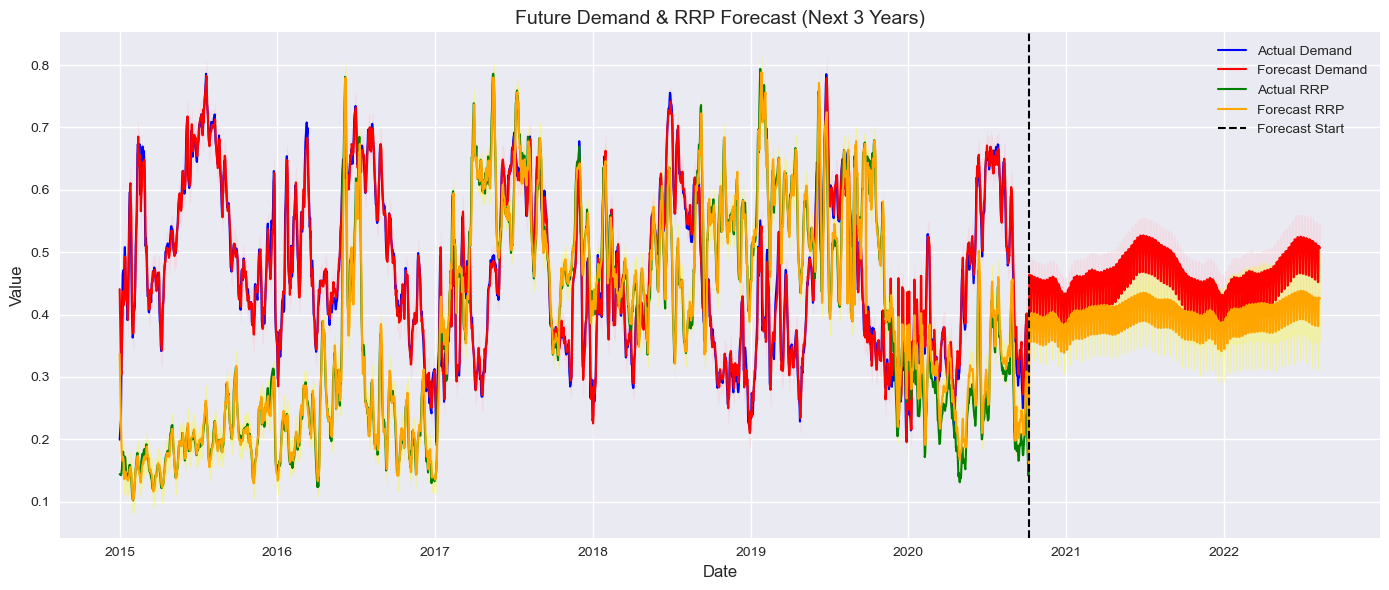

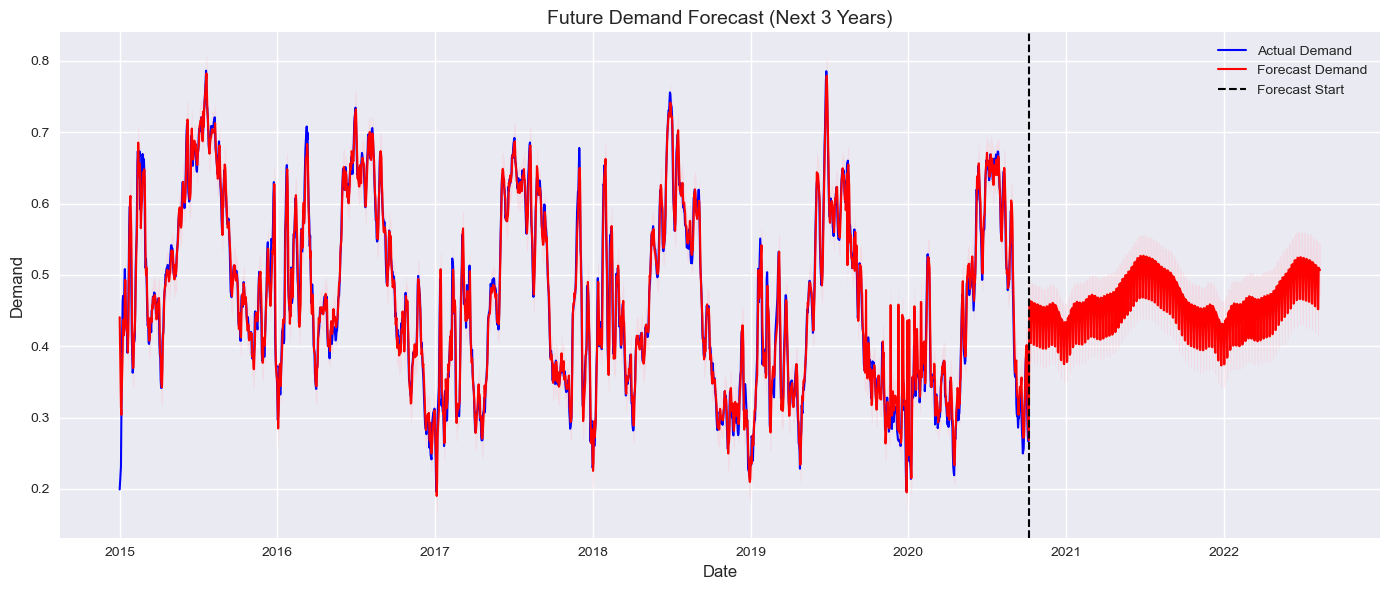

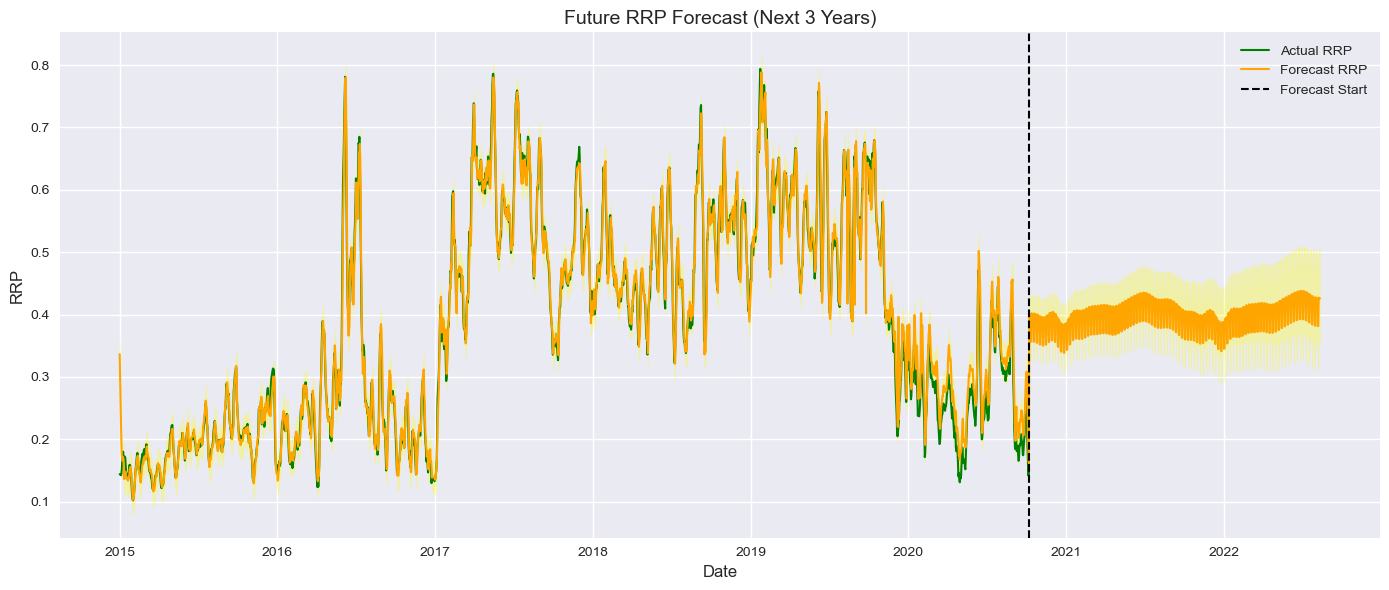

Demand Forecast Accuracy (Prophet):
MAE: 0.0162, RMSE: 0.0206

RRP Forecast Accuracy (Prophet):
MAE: 0.0269, RMSE: 0.0319

Additional Accuracy Evaluation (Percentage Range) - Prophet:
Demand Accuracy: 95.62%, RRP Accuracy: 90.08%


In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle

# Load dataset
df = pd.read_csv('./cleaned_dataset_2.csv')

# Ensure date column is present and valid
if 'date' not in df.columns or df['date'].isna().all():
    print("🚨 Date column is missing! Reconstructing...")
    df['date'] = pd.date_range(start='2020-01-01', periods=len(df), freq='D')
else:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Create lag features for demand and rrp
df['demand_lag_1'] = df['demand'].shift(1)
df['demand_lag_7'] = df['demand'].shift(7)
df['rrp_lag_1'] = df['rrp'].shift(1)
df['rrp_lag_7'] = df['rrp'].shift(7)

# Create interaction term for weather effects
df['temp_rain_interaction'] = df['min_temperature'] * df['rainfall']

df['weekday'] = df['date'].dt.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
df['extreme_weather'] = ((df['max_temperature'] > df['max_temperature'].quantile(0.95)) | 
                         (df['rainfall'] > df['rainfall'].quantile(0.95))).astype(int)

df['ds'] = df['date'].copy()
df = df.dropna(subset=['ds'])

# Scaling
scaler = StandardScaler()
features_to_scale = ['demand', 'demand_lag_1', 'demand_lag_7', 'rrp', 'rrp_lag_1', 'rrp_lag_7',
                     'min_temperature', 'max_temperature', 'solar_exposure',
                     'rainfall', 'temp_rain_interaction']

# Fill missing values using column mean before rolling mean
for col in features_to_scale:
    df[col].fillna(df[col].mean(), inplace=True)
    df[col] = df[col].rolling(window=7, min_periods=1).mean()

# Handle lags properly
df[['demand_lag_1', 'demand_lag_7', 'rrp_lag_1', 'rrp_lag_7']].fillna(method='bfill', inplace=True)

# Forward and backward fill any remaining NaNs
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Debug: Check for NaNs before dropping rows
nan_report = df[features_to_scale].isna().sum()
print("NaN count before dropping:")
print(nan_report)

if nan_report.sum() > 0:
    print(f"🚨 Remaining NaNs (after all filling attempts):\n{nan_report}")

df = df.dropna(subset=features_to_scale)
if df.empty:
    raise ValueError("🚨 All rows have NaNs after preprocessing! Check data integrity.")

# Scale features
scaled_features = scaler.fit_transform(df[features_to_scale])
scaled_df = pd.DataFrame(scaled_features, columns=features_to_scale)
scaled_df['is_weekend'] = df['is_weekend'].values
scaled_df['extreme_weather'] = df['extreme_weather'].values
scaled_df['ds'] = df['ds'].values
scaled_df['y_demand'] = df['demand'].values
scaled_df['y_rrp'] = df['rrp'].values
scaled_df = scaled_df.dropna(subset=['y_demand', 'y_rrp'])
scaled_df['ds'] = pd.to_datetime(scaled_df['ds'])

# Split Data
train_size = int(len(scaled_df) * 0.8)
train_df = scaled_df.iloc[:train_size]
test_df = scaled_df.iloc[train_size:]

print(f"Train size: {train_df.shape}, Test size: {test_df.shape}")
print(train_df.head())

# Train Prophet Model for Demand
model_demand = Prophet()
regressor_cols = ['demand_lag_1', 'demand_lag_7', 'rrp_lag_1', 'rrp_lag_7',
                  'min_temperature', 'max_temperature', 'solar_exposure',
                  'rainfall', 'temp_rain_interaction', 'is_weekend', 'extreme_weather']
for col in regressor_cols:
    model_demand.add_regressor(col)

# Rename 'y_demand' to 'y' as required by Prophet
train_df_demand = train_df[['ds', 'y_demand'] + regressor_cols].rename(columns={'y_demand': 'y'})
# Fit the Prophet model for Demand
model_demand.fit(train_df_demand)

# Train Prophet Model for RRP
model_rrp = Prophet()
for col in regressor_cols:
    model_rrp.add_regressor(col)

# Rename 'y_rrp' to 'y' as required by Prophet
train_df_rrp = train_df[['ds', 'y_rrp'] + regressor_cols].rename(columns={'y_rrp': 'y'})
model_rrp.fit(train_df_rrp)

# # Save the models to disk
# with open('model_demand.pkl', 'wb') as f:
#     pickle.dump(model_demand, f)

# with open('model_rrp.pkl', 'wb') as f:
#     pickle.dump(model_rrp, f)

# Create a future dataframe for the next 3 years (1095 days)
future = model_demand.make_future_dataframe(periods=1095, freq='D')

# Merge the additional regressor data from scaled_df
future = future.merge(
    scaled_df[['ds'] + regressor_cols],
    on='ds', how='left', suffixes=('', '_new')
)

# Overwrite existing regressor columns if new values were merged
for col in regressor_cols:
    if col + '_new' in future.columns:
        future[col] = future[col + '_new']
        future.drop(columns=[col + '_new'], inplace=True)

# Fill any missing regressor values with the mean from scaled_df
for col in regressor_cols:
    future[col].fillna(scaled_df[col].mean(), inplace=True)

# Predict future demand and rrp
forecast_demand = model_demand.predict(future)
forecast_rrp = model_rrp.predict(future)

# Use a cleaner style for plots
plt.style.use('seaborn-v0_8')

# Plot actual vs. future forecasts for Demand and RRP
plt.figure(figsize=(14, 6))
plt.plot(scaled_df['ds'], scaled_df['y_demand'], label='Actual Demand', color='blue', linewidth=1.5)
plt.plot(forecast_demand['ds'], forecast_demand['yhat'], label='Forecast Demand', color='red', linewidth=1.5)
plt.fill_between(
    forecast_demand['ds'],
    forecast_demand['yhat_lower'],
    forecast_demand['yhat_upper'],
    color='pink', alpha=0.3
)
plt.plot(scaled_df['ds'], scaled_df['y_rrp'], label='Actual RRP', color='green', linewidth=1.5)
plt.plot(forecast_rrp['ds'], forecast_rrp['yhat'], label='Forecast RRP', color='orange', linewidth=1.5)
plt.fill_between(
    forecast_rrp['ds'],
    forecast_rrp['yhat_lower'],
    forecast_rrp['yhat_upper'],
    color='yellow', alpha=0.3
)
plt.axvline(test_df['ds'].max(), color='black', linestyle='--', label='Forecast Start', linewidth=1.5)
plt.title('Future Demand & RRP Forecast (Next 3 Years)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Filter forecasts matching the test dates for both demand and rrp
test_forecast_demand = test_df[['ds', 'y_demand']].merge(
    forecast_demand[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds'
)
test_forecast_rrp = test_df[['ds', 'y_rrp']].merge(
    forecast_rrp[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds'
)

# Compute accuracy metrics for Demand
mae_demand = mean_absolute_error(test_forecast_demand['y_demand'], test_forecast_demand['yhat'])
rmse_demand = np.sqrt(mean_squared_error(test_forecast_demand['y_demand'], test_forecast_demand['yhat']))

# Compute accuracy metrics for RRP
mae_rrp = mean_absolute_error(test_forecast_rrp['y_rrp'], test_forecast_rrp['yhat'])
rmse_rrp = np.sqrt(mean_squared_error(test_forecast_rrp['y_rrp'], test_forecast_rrp['yhat']))

# Plot Demand forecast with cleaner style
plt.figure(figsize=(14, 6))
plt.plot(scaled_df['ds'], scaled_df['y_demand'], label='Actual Demand', color='blue', linewidth=1.5)
plt.plot(forecast_demand['ds'], forecast_demand['yhat'], label='Forecast Demand', color='red', linewidth=1.5)
plt.fill_between(
    forecast_demand['ds'],
    forecast_demand['yhat_lower'],
    forecast_demand['yhat_upper'],
    color='pink', alpha=0.3
)
plt.axvline(test_df['ds'].max(), color='black', linestyle='--', label='Forecast Start', linewidth=1.5)
plt.title('Future Demand Forecast (Next 3 Years)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Demand', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Plot RRP forecast with cleaner style
plt.figure(figsize=(14, 6))
plt.plot(scaled_df['ds'], scaled_df['y_rrp'], label='Actual RRP', color='green', linewidth=1.5)
plt.plot(forecast_rrp['ds'], forecast_rrp['yhat'], label='Forecast RRP', color='orange', linewidth=1.5)
plt.fill_between(
    forecast_rrp['ds'],
    forecast_rrp['yhat_lower'],
    forecast_rrp['yhat_upper'],
    color='yellow', alpha=0.3
)
plt.axvline(test_df['ds'].max(), color='black', linestyle='--', label='Forecast Start', linewidth=1.5)
plt.title('Future RRP Forecast (Next 3 Years)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('RRP', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Print accuracy metrics using actual (unscaled) values
print("Demand Forecast Accuracy (Prophet):")
print(f"MAE: {mae_demand:.4f}, RMSE: {rmse_demand:.4f}")
print("\nRRP Forecast Accuracy (Prophet):")
print(f"MAE: {mae_rrp:.4f}, RMSE: {rmse_rrp:.4f}")

# Additional accuracy evaluation in percentage (100% range)
mape_demand = np.mean(np.abs((test_forecast_demand['y_demand'] - test_forecast_demand['yhat']) / test_forecast_demand['y_demand'])) * 100
mape_rrp = np.mean(np.abs((test_forecast_rrp['y_rrp'] - test_forecast_rrp['yhat']) / test_forecast_rrp['y_rrp'])) * 100
accuracy_demand = 100 - mape_demand
accuracy_rrp = 100 - mape_rrp

print("\nAdditional Accuracy Evaluation (Percentage Range) - Prophet:")
print(f"Demand Accuracy: {accuracy_demand:.2f}%, RRP Accuracy: {accuracy_rrp:.2f}%")